<a href="https://colab.research.google.com/github/ArifAygun/Iron-Ore-Froth-Flotation-Quality-Prediction/blob/main/AA_Iron_Ore_Froth_Flotation_Quality_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Quality Prediction of Iron Ore Mining Flotation Process**

##**1. Problem Definition**

**Gangue concentrate predict in the reverse cationic flotation:**


Mined ores are mostly mixtures of extractable minerals and nonvaluable material (gangue). Mineral processing (e.g. ore dressing, ore beneficiation) follows mining and prepares the ore for extraction of the valuable metal. A principal step in mineral processing is physical separation of the particles of valuable minerals from the gangue, to produce an enriched portion (concentrate) containing most of the valuable minerals, and a discard (tailing) containing predominantly the gangue.

A separation of minerals by exploiting difference of surface properties (hydrophobicity) is called flotation. **The reverse cationic flotation** is commonly used to separate iron from silica. By adjusting the 'chemistry' of the pulp by adding various chemical reagents, iron minerals remain in the water and create sediment with a high concentration of iron (valuable minerals). At the same time, silica particles (gangue) attach to air bubbles and float to the surface.

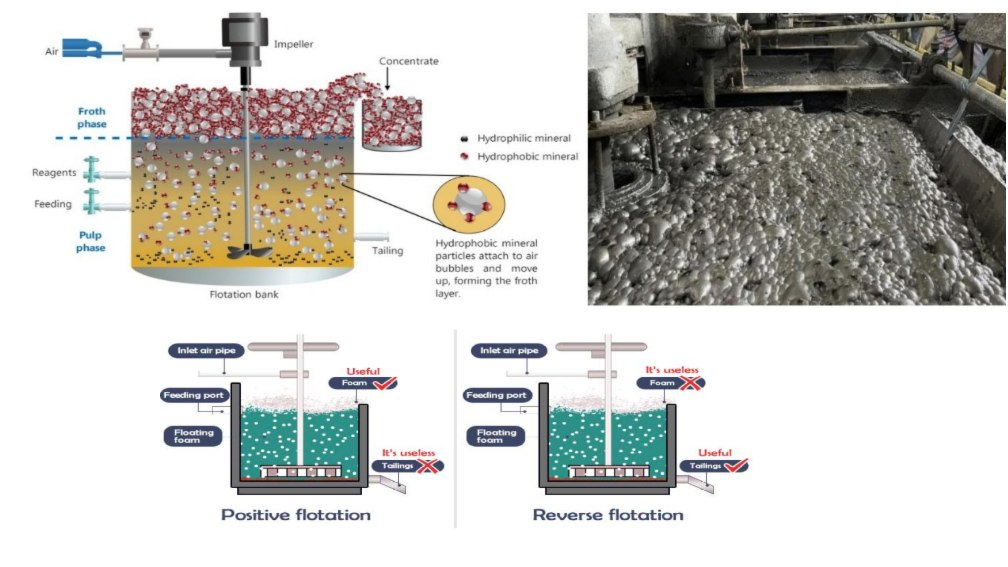

Flotation concentrate is periodically sampled to determine its purity (i.e., *%valuable*, *%gangue*). Higher *%gangue* in the concentrate is undesirable as it indicates that most valuable minerals had gone into the tailing. Purity measurement is usually done in a lab and can take some time before process engineers can make any adjustments based on the results. A timely investigation of concentrate purity is, therefore, a fundamental aspect for the control and optimization of the flotation process.

This project explores the application of machine learning to predict gangue (*%silica*) in the flotation concentrate. The prediction will help process engineers assess purity of flotation concentrate and take corrective actions in advance. More specifically, the goal is to tackle the following task:
- **To predict the last column (dependent variable), which is the % of silica in the iron ore concentrate.**

##**2. Data Understanding**

###**2.1. Data Definitions**

- **Date**: Data collection time.
- **% Iron Feed**: Feed grade of iron-containing ore.
- **% Silica Feed**: Feed grade of silica-containing ore.
- **Starch Flow**: Depressant chemical for Iron(Fe) containing ore measured in m³/h.
- **Amina Flow**: Collector chemical for Silica containing ore measured in m³/h.
- **Ore Pulp Flow**: The amount of pulp flow fed to the flotation columns as the product of the previous process step measured in t/h.
- **Ore Pulp pH**: pH is measured in pH scale.
- **Ore Pulp Density**: The solid percent of ore fed density ranges in kg/cm³
- **Flotation Column 01, 02, 03, 04, 05, 06, 07 Air Flow**: Air Flows that goes into the flotation cell measured in Nm³/h.
- **Flotation Column 01, 02, 03, 04, 05, 06, 07 Level**: Froth level in the flotation cell measured in mm.
- **% Iron Concentrate**: Concentrate grade of iron-containing ore in percentage.
- **% Silica Concentrate**: Concentrate grade of silica-containing ore in percentage

###**2.2. Inspection of the data**

- The first column shows time and date range (march 2017 -  september 2017). 
- Some columns were sampled every 20 second. Others were sampled on a hourly base.
- The second and third columns are quality measures of the iron ore pulp right before it is fed into the flotation plant. 
- From Column 4 until column 8 are the most important variables that impact in the ore quality in the end of the process. 
- From column 9 until column 22, we can see process data (froth level and air flow inside the flotation columns, which also impact in ore quality). 
- The last two columns are the final iron ore pulp quality measurement from the lab. 

##**3. Data Collection**

###**3.1. Import libraries modules and dataset**

In [158]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, boxcox
import os
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler

In [159]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/Flotation/

flotation = pd.read_csv('Flotation_Plant.csv', decimal = ",")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Flotation


###**3.2. Reduce memory usage**

In [160]:
# Use a function to reduce memory usage of the dataframe by modifying the datatypes
def reduce_mem_usage(flotation, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = flotation.memory_usage().sum() / 1024**2    
    for col in flotation.columns:
        col_type = flotation[col].dtypes
        if col_type in numerics:
            c_min = flotation[col].min()
            c_max = flotation[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    flotation[col] = flotation[col].astype(np.int8)
                elif c_min > flotation.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       flotation[col] = flotation[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    flotation[col] = flotation[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    flotation[col] = flotation[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    flotation[col] = flotation[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    flotation[col] = flotation[col].astype(np.float32)
                else:
                    flotation[col] = flotation[col].astype(np.float64)    
    end_mem = flotation.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return flotation

In [161]:
flotation = reduce_mem_usage(flotation)

Mem. usage decreased to 70.33 Mb (47.9% reduction)


- Memory usage decrased from 135.0+ MB to 70.33 MB

##**4. Data Preprocessing**

###**4.1. Dataset information**

In [162]:
flotation.head().T

,0,1,2,3,4
date,2017-03-10 01:00:00,2017-03-10 01:00:00,2017-03-10 01:00:00,2017-03-10 01:00:00,2017-03-10 01:00:00
% Iron Feed,55.200001,55.200001,55.200001,55.200001,55.200001
% Silica Feed,16.98,16.98,16.98,16.98,16.98
Starch Flow,3019.530029,3024.409912,3043.459961,3047.360107,3033.689941
Amina Flow,557.434021,563.965027,568.054016,568.664978,558.166992
Ore Pulp Flow,395.713013,397.382996,399.667999,397.938995,400.253998
Ore Pulp pH,10.0664,10.0672,10.068,10.0689,10.0697
Ore Pulp Density,1.74,1.74,1.74,1.74,1.74
Flotation Column 01 Air Flow,249.214005,249.718994,249.740997,249.917007,250.203003
Flotation Column 02 Air Flow,253.235001,250.531998,247.873993,254.487,252.136002


In [163]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   date                          737453 non-null  object 
 1   % Iron Feed                   737453 non-null  float32
 2   % Silica Feed                 737453 non-null  float32
 3   Starch Flow                   737453 non-null  float32
 4   Amina Flow                    737453 non-null  float32
 5   Ore Pulp Flow                 737453 non-null  float32
 6   Ore Pulp pH                   737453 non-null  float32
 7   Ore Pulp Density              737453 non-null  float32
 8   Flotation Column 01 Air Flow  737453 non-null  float32
 9   Flotation Column 02 Air Flow  737453 non-null  float32
 10  Flotation Column 03 Air Flow  737453 non-null  float32
 11  Flotation Column 04 Air Flow  737453 non-null  float32
 12  Flotation Column 05 Air Flow  737453 non-nul

- 7 Flotation Column Air Flow columns have similar values, transform to 1 column
- 7 Flotation Column Level columns have similar values, transform to 1 column
- For further analysis "date" column will not be used,
- Therefore we will drop unnecessary columns. 

In [164]:
flotation['Flotation Column Air Flow'] = flotation[['Flotation Column 01 Air Flow', 
                                                  'Flotation Column 02 Air Flow',
                                                  'Flotation Column 03 Air Flow',
                                                  'Flotation Column 04 Air Flow',
                                                  'Flotation Column 05 Air Flow',
                                                  'Flotation Column 06 Air Flow',
                                                  'Flotation Column 07 Air Flow']].mean(axis=1)

flotation['Flotation Column Air Level'] = flotation[['Flotation Column 01 Level',
                                                   'Flotation Column 02 Level',
                                                   'Flotation Column 03 Level',
                                                   'Flotation Column 04 Level',
                                                   'Flotation Column 05 Level',
                                                   'Flotation Column 06 Level',
                                                   'Flotation Column 07 Level']].mean(axis=1)

flotation.drop(['Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
                'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
                'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
                'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
                'Flotation Column 02 Level', 'Flotation Column 03 Level',
                'Flotation Column 04 Level', 'Flotation Column 05 Level',
                'Flotation Column 06 Level', 'Flotation Column 07 Level'], axis=1, inplace=True)

flotation.drop('date', axis=1, inplace=True)

column_order = ['% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow', 'Ore Pulp Flow',
                'Ore Pulp pH', 'Ore Pulp Density', 'Flotation Column Air Flow',
                'Flotation Column Air Level', '% Iron Concentrate', '% Silica Concentrate']

flotation = flotation.reindex(columns=column_order)

flotation.head().T

,0,1,2,3,4
% Iron Feed,55.200001,55.200001,55.200001,55.200001,55.200001
% Silica Feed,16.980000,16.980000,16.980000,16.980000,16.980000
Starch Flow,3019.530029,3024.409912,3043.459961,3047.360107,3033.689941
Amina Flow,557.434021,563.965027,568.054016,568.664978,558.166992
Ore Pulp Flow,395.713013,397.382996,399.667999,397.938995,400.253998
Ore Pulp pH,10.066400,10.067200,10.068000,10.068900,10.069700
Ore Pulp Density,1.740000,1.740000,1.740000,1.740000,1.740000
Flotation Column Air Flow,265.090027,264.534271,264.119995,265.359711,264.663025
Flotation Column Air Level,461.548431,457.548035,456.466980,448.064392,448.784698
% Iron Concentrate,66.910004,66.910004,66.910004,66.910004,66.910004


In [165]:
flotation.shape

(737453, 11)

###**4.2. Rename the columns**

In [166]:
# Rename column names
old_columns = ['% Iron Feed', '% Silica Feed', 'Starch Flow','Amina Flow', 
               'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
               'Flotation Column Air Flow', 'Flotation Column Air Level', 
               '% Iron Concentrate', '% Silica Concentrate']

new_columns = ["iron_feed", "silica_feed", "starch_flow", "amina_flow", 
               "pulp_flow", "pulp_pH", "pulp_density", "airflow_col", 
               "level_col", "iron_conc", "silica_conc"]

flotation = flotation.rename(columns=dict(zip(old_columns, new_columns)))
flotation.columns

Index(['iron_feed', 'silica_feed', 'starch_flow', 'amina_flow', 'pulp_flow',
       'pulp_pH', 'pulp_density', 'airflow_col', 'level_col', 'iron_conc',
       'silica_conc'],
      dtype='object')

###**4.3. Check Missing & Duplicated Values**

In [167]:
missing_values = flotation.isnull().sum()
print(missing_values)

iron_feed       0
silica_feed     0
starch_flow     0
amina_flow      0
pulp_flow       0
pulp_pH         0
pulp_density    0
airflow_col     0
level_col       0
iron_conc       0
silica_conc     0
dtype: int64


- No missing values across the dataframe

In [168]:
#check duplicated rows
duplicate_rows = flotation[flotation.duplicated()]
duplicate_rows.shape

(1183, 11)

- There are 1171 duplicated values

In [169]:
#drop duplicated rows
flotation = flotation.drop_duplicates()

- Now dataset has 736282 data points.

In [170]:
flotation.shape

(736270, 11)

###**4.4. Dataset summary statistics**

In [171]:
flotation.describe()

,iron_feed,silica_feed,starch_flow,amina_flow,pulp_flow,pulp_pH,pulp_density,airflow_col,level_col,iron_conc,silica_conc
count,736270.000000,736270.000000,736270.000000,736270.000000,736270.000000,736270.000000,736270.000000,736270.000000,736270.000000,736270.000000,736270.000000
mean,56.298321,14.648991,2869.632568,488.166473,397.570923,9.767312,1.680424,288.636963,467.152893,65.049126,2.327266
std,5.160407,6.810795,1216.024536,91.253868,9.705303,0.387178,0.069206,18.708809,78.383636,1.118708,1.125624
min,42.740002,1.310000,0.002026,241.669006,376.248993,8.753340,1.519820,218.458984,255.408813,62.049999,0.600000
25%,52.669998,8.940000,2075.052551,431.837006,394.247986,9.527050,1.647390,277.783577,399.512703,64.370003,1.440000
50%,56.080002,13.850000,3020.229980,504.352997,399.238007,9.797460,1.697580,298.655319,455.928223,65.209999,2.000000
75%,59.720001,19.600000,3728.949951,553.335999,402.967010,10.037800,1.728380,300.461700,517.530960,65.860001,3.010000
max,65.779999,33.400002,6300.229980,739.538025,418.640991,10.808100,1.853250,330.498718,746.034668,68.010002,5.530000



- **iron_feed**: Percentage of iron in the slurry being fed to the flotation cells (0-100%). (Min 42.74%, max 65.78%)
- **silica_feed**: Percentage of silica in the slurry being fed to the flotation cells. (0-100%). (Min 1.31%, max 33.4%)
- **starch_flow**: Flow rate of starch (reactive) measured in m3/h. (min 0.002026 m3/h, max 6300.23 m3/h)
- **amina_flow**: Flow rate of amine (reactive) measured in m3/h. (min 241.669 m3/h, max 739.538 m3/h)
- **pulp_flow**: Feed flow rate of pulp measured in t/h. (min 376.249 t/h, max 418.641 m3/h)
- **pulp_pH**: pH of the pulp, scale from 0 to 14. (min 8.7533 ph, max 10.808ph)
- **pulp_density**: Density of the pulp measured in kg/cm³. (min 1.519 kg/cm3, max 1.853 kg/cm3)
- **airflow_col**: Air flow rate entering flotation cell 1, measured in Nm³/h. (min 218.459 Nm3/h, max 330.499 Nm3/h)
- **level_col**: Height of the bubble layer at the top of flotation cell 1, measured in mm. (min 255.409 mm, max 746.035 mm)

**```Target Variable```**
- **silica_conc**: Percentage of silica in the concentrate at the end of the flotation process, (min 0.6%, max 5.63%) 

- Dataset variables have very wide range data point values.


###**4.5. Dataset normalisation**

- Normalizing the dataset is necessary to bring the features or variables to a similar scale or range.

In [172]:
from sklearn.preprocessing import MinMaxScaler

# Select the columns to normalize
columns_to_normalize = ["iron_feed", "silica_feed", "starch_flow", "amina_flow", 
                        "pulp_flow", "pulp_pH", "pulp_density", "airflow_col", 
                        "level_col", "iron_conc", "silica_conc"]

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Apply Min-Max scaling to the selected columns
flotation[columns_to_normalize] = scaler.fit_transform(flotation[columns_to_normalize])


In [173]:
flotation.head().T

,0,1,2,3,4
iron_feed,0.540799,0.540799,0.540799,0.540799,0.540799
silica_feed,0.488314,0.488314,0.488314,0.488314,0.488314
starch_flow,0.479273,0.480047,0.483071,0.483690,0.481520
amina_flow,0.634233,0.647351,0.655564,0.656791,0.635705
pulp_flow,0.459144,0.498538,0.552440,0.511653,0.566262
pulp_pH,0.639033,0.639422,0.639812,0.640250,0.640639
pulp_density,0.660348,0.660348,0.660348,0.660348,0.660348
airflow_col,0.416201,0.411241,0.407543,0.418608,0.412390
level_col,0.420156,0.412003,0.409799,0.392673,0.394141
iron_conc,0.815436,0.815436,0.815436,0.815436,0.815436


In [174]:
# describe dataset after normalisation
flotation.describe().T

,count,mean,std,min,25%,50%,75%,max
iron_feed,736270.0,0.588468,0.223976,0.0,0.430990,0.578993,0.736979,1.0
silica_feed,736270.0,0.415674,0.212240,0.0,0.237769,0.390776,0.569959,1.0
starch_flow,736270.0,0.455480,0.193013,0.0,0.329361,0.479384,0.591875,1.0
amina_flow,736270.0,0.495105,0.183289,0.0,0.381964,0.527617,0.626002,1.0
pulp_flow,736270.0,0.502972,0.228942,0.0,0.424584,0.542296,0.630260,1.0
pulp_pH,736270.0,0.493476,0.188430,0.0,0.376545,0.508147,0.625114,1.0
pulp_density,736270.0,0.481671,0.207559,0.0,0.382599,0.533125,0.625498,1.0
airflow_col,736270.0,0.626366,0.166984,0.0,0.529496,0.715785,0.731907,1.0
level_col,736270.0,0.431580,0.159763,0.0,0.293714,0.408701,0.534261,1.0
iron_conc,736270.0,0.503206,0.187703,0.0,0.389262,0.530201,0.639261,1.0


###**4.7. Corellation between the variables**

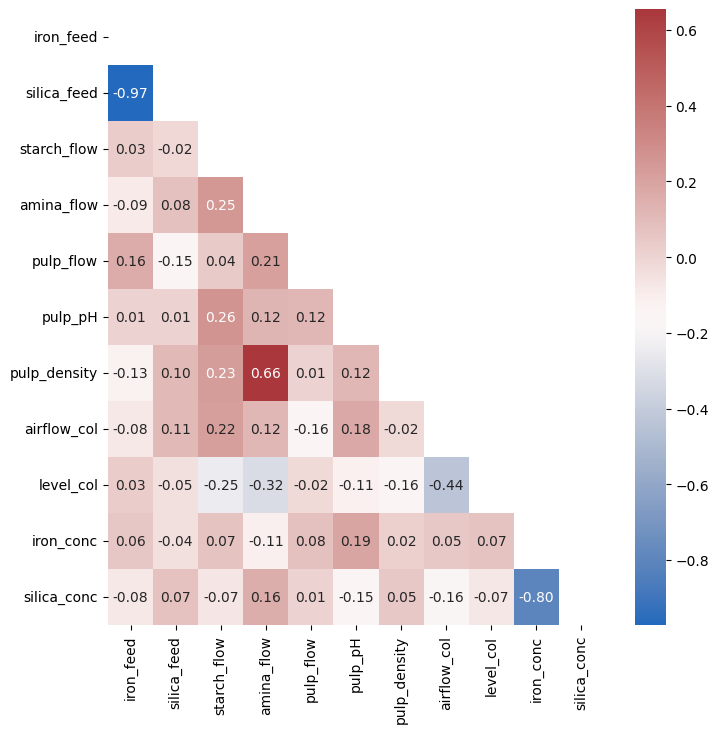

In [175]:
mask = np.triu(np.ones_like(flotation.corr(), dtype=bool))
plt.figure(figsize=(8, 8))
sns.heatmap(flotation.corr(), annot=True, fmt='.2f', cmap='vlag', 
            annot_kws={"fontsize": 10}, mask=mask)
plt.show()


- ```iron_feed```  variable is highly correlated with ```silica_feed```
- ```silica_conc```  variable is highly correlated with ```iron_conc``` 

We will drop ```iron_feed```, ```iron_conc```

In [176]:
flotation.drop(['iron_feed', 'iron_conc'], axis=1, inplace=True)

In [177]:
flotation.shape

(736270, 9)

###**4.8. Check & remove outliers**

- Visualize the variables for seeing outliers

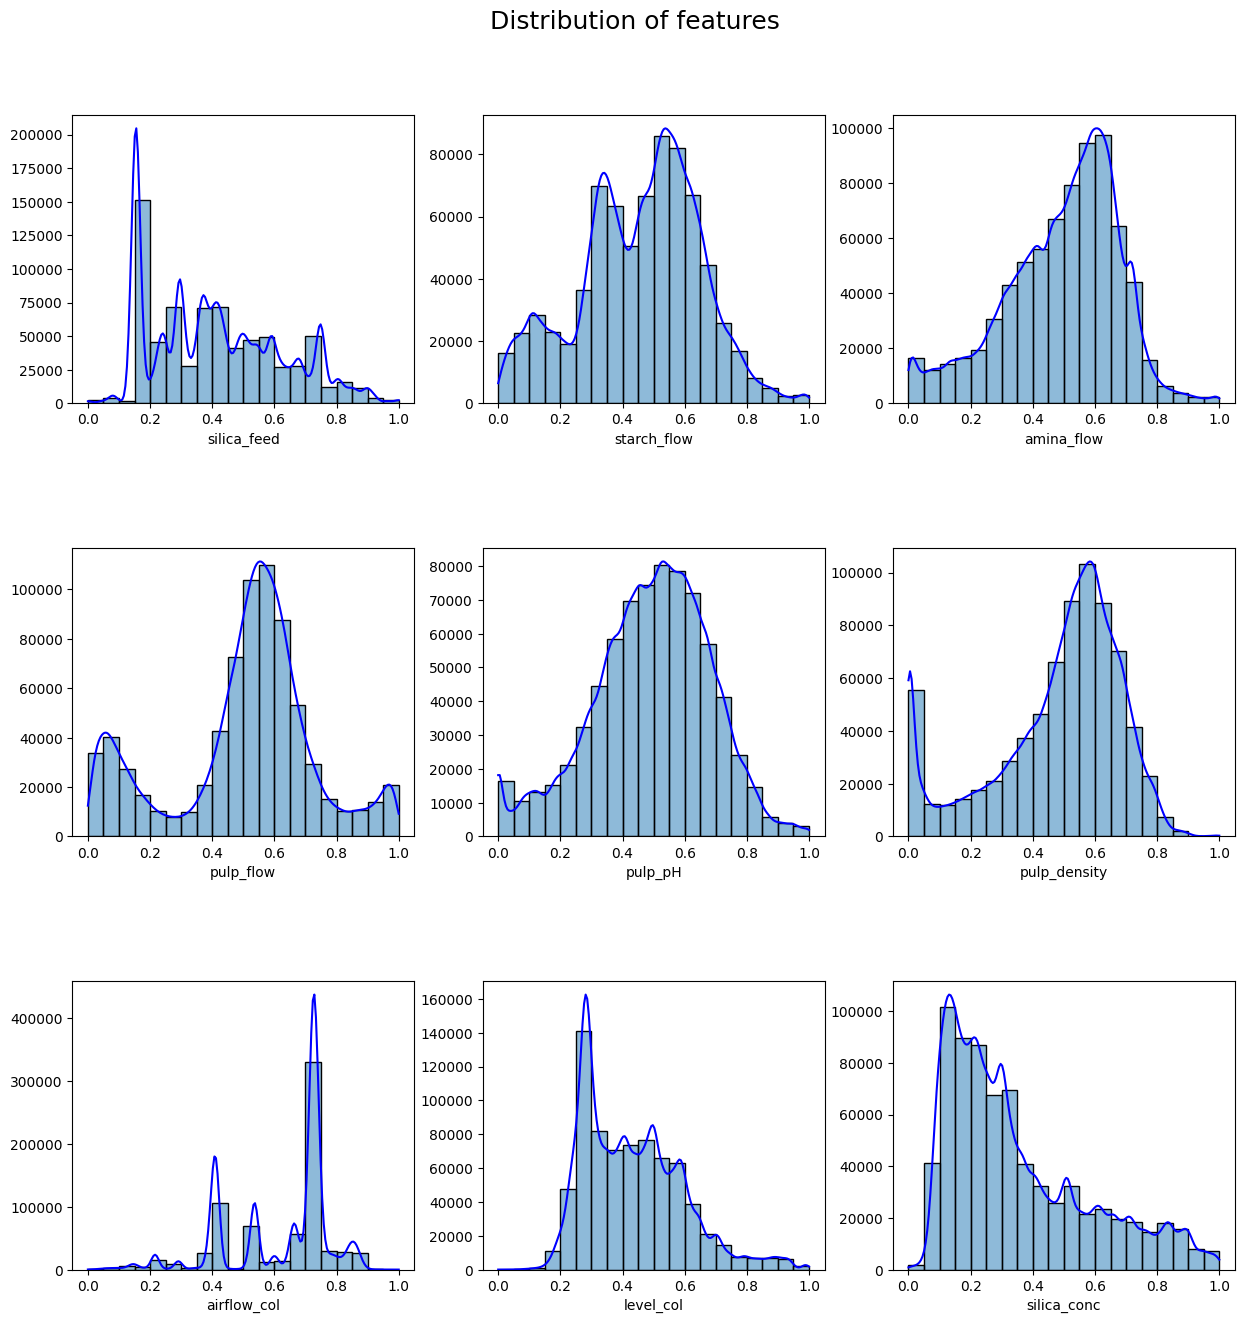

In [178]:
# histogram of the features
features = flotation.columns
plt.figure(figsize= (15,15))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Distribution of features", fontsize=18, y=0.95)
for i, feature in enumerate(features):
 k = i + 1
 plt.subplot(3,3,int(k))
 sns.histplot(data=flotation, x=feature, kde=True, bins = 20).lines[0].set_color('blue')
 plt.xlabel(feature)
 plt.ylabel("")
plt.show()

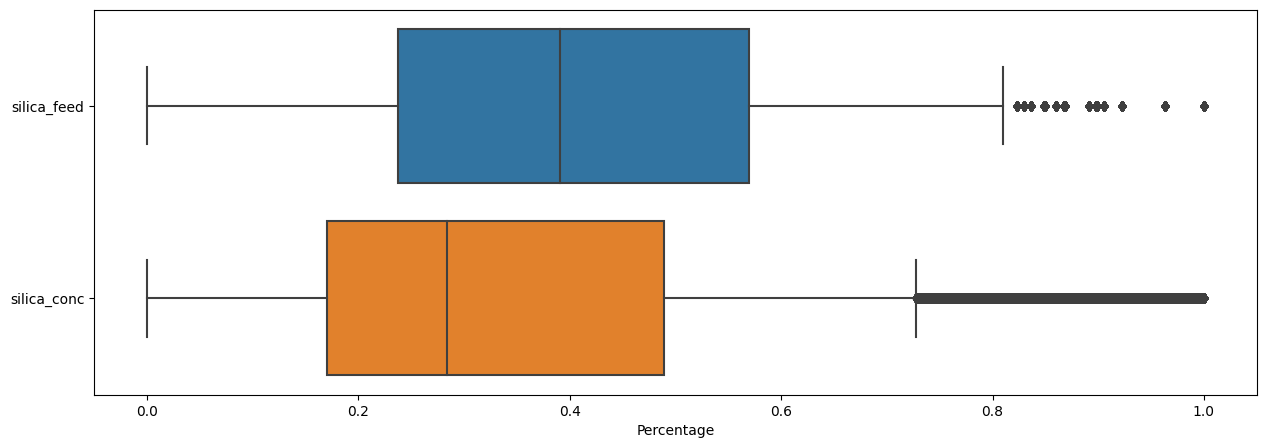

In [179]:
#box plots of input and output values with whisker is 0.75
plt.figure(figsize = (15, 5))
sns.boxplot(data = flotation[["silica_feed", "silica_conc"]], whis=0.75, orient = 'h')
plt.xlabel('Percentage');

- Detecting the outliers  of ```silica_feed```, ```silica_conc``` using IQR and removing them

In [180]:
variables = ["silica_feed", "silica_conc"]

for variable in variables:
    # Calculate the upper and lower limits
    Q1 = flotation[variable].quantile(0.25)
    Q3 = flotation[variable].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Create arrays of Boolean values indicating the outlier rows
    upper_array = np.where(flotation[variable] >= upper)[0]
    lower_array = np.where(flotation[variable] <= lower)[0]

    # Removing the outliers
    flotation.drop(index=upper_array, inplace=True)
    flotation.drop(index=lower_array, inplace=True)

print("New Shape: ", flotation.shape)


New Shape:  (731513, 9)


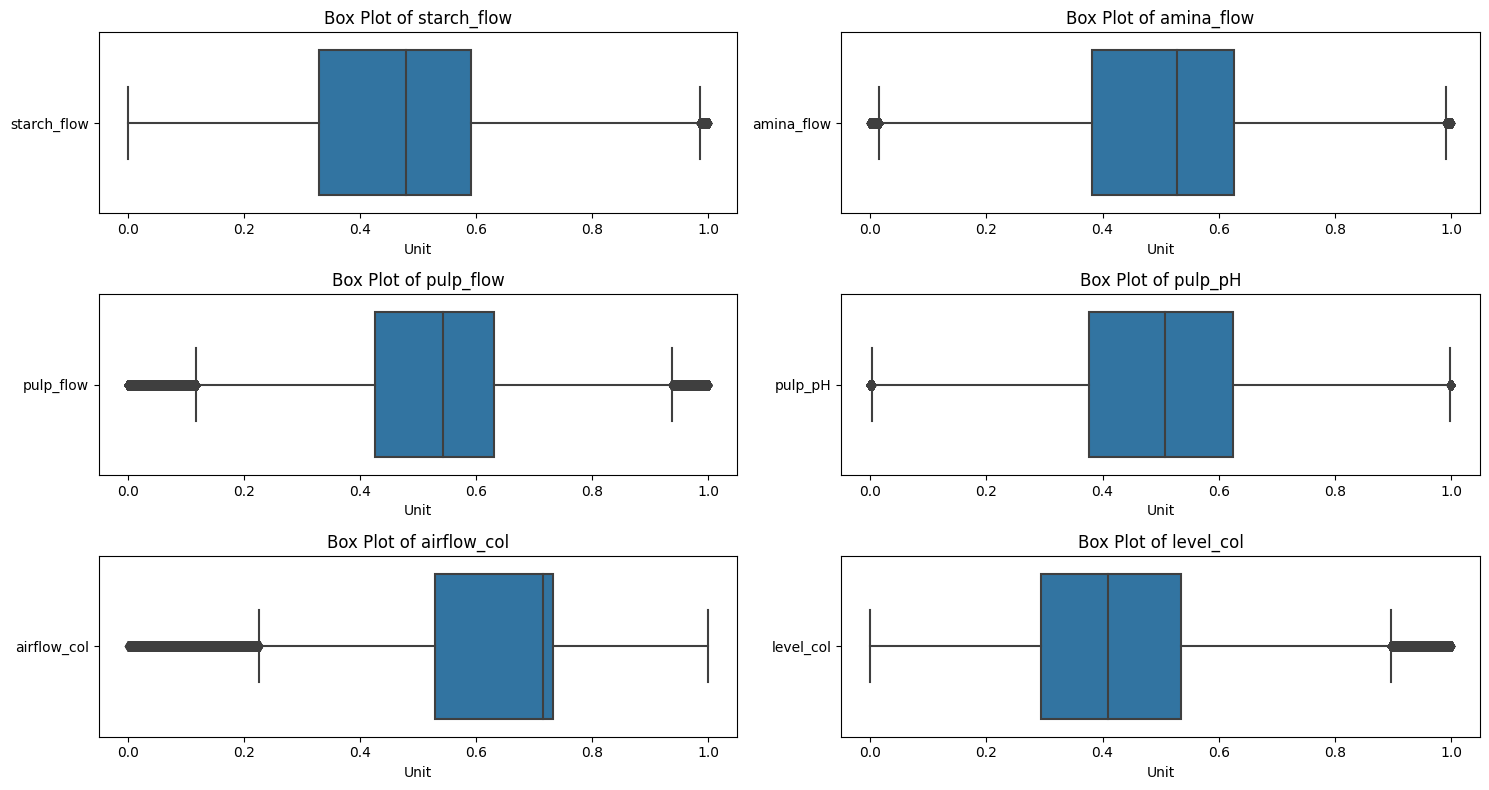

In [181]:
variables = ["starch_flow", "amina_flow", "pulp_flow", 
             "pulp_pH", "airflow_col", "level_col"]
fig, axes = plt.subplots(3, 2, figsize=(15, 8))

for i, variable in enumerate(variables):
    row = i // 2
    col = i % 2

    # Box plot for the current variable
    sns.boxplot(data=flotation[[variable]], orient='h', ax=axes[row, col])
    axes[row, col].set_xlabel('Unit')
    axes[row, col].set_title('Box Plot of ' + variable)

plt.tight_layout()
plt.show()


In [182]:
variables = ["silica_feed", "starch_flow", "amina_flow", "pulp_flow", 
             "pulp_pH", "pulp_density", "airflow_col", "level_col"]

for variable in variables:
    # Calculate the upper and lower limits
    Q1 = flotation[variable].quantile(0.25)
    Q3 = flotation[variable].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Create arrays of Boolean values indicating the outlier rows
    upper_array = np.where(flotation[variable] >= upper)[0]
    lower_array = np.where(flotation[variable] <= lower)[0]

    # Check if the outlier arrays have elements
    if upper_array.size > 0 and lower_array.size > 0:
        # Find common indices between outlier arrays and DataFrame index
        common_indices = set(upper_array) & set(lower_array)

        # Removing the outliers using common indices
        flotation.drop(index=common_indices, inplace=True)

print("New Shape: ", flotation.shape)

New Shape:  (731513, 9)


###**4.7. Check & adjust skewness**

- We will check the target variable ```silica_conc``` skewness

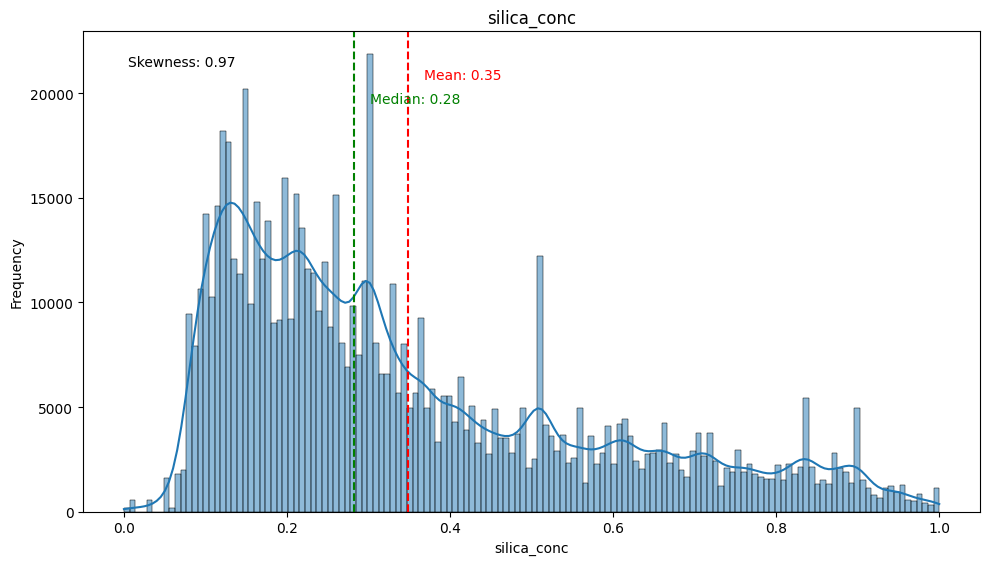

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew

fig, ax = plt.subplots(figsize=(10, 6))

data = flotation['silica_conc']
skewness = skew(data)

sns.histplot(data, kde=True, ax=ax)
ax.axvline(data.mean(), color='r', linestyle='--')
ax.axvline(data.median(), color='g', linestyle='--')

ax.text(data.mean() + 0.02 * (data.max() - data.min()), 
        0.9 * ax.get_ylim()[1], f'Mean: {data.mean():.2f}', color='r')
ax.text(data.median() + 0.02 * (data.max() - data.min()), 
        0.85 * ax.get_ylim()[1], f'Median: {data.median():.2f}', color='g')

ax.text(0.05, 0.95, f'Skewness: {skewness:.2f}', 
        transform=ax.transAxes, ha='left', va='top')
ax.set_title('silica_conc')
ax.set_xlabel('silica_conc')
ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the top spacing here
plt.show()



- Skewness of the target variable ```silica_conc``` is 0.97 (right skewed)

We will use boxcox transformation method for target variable adjust

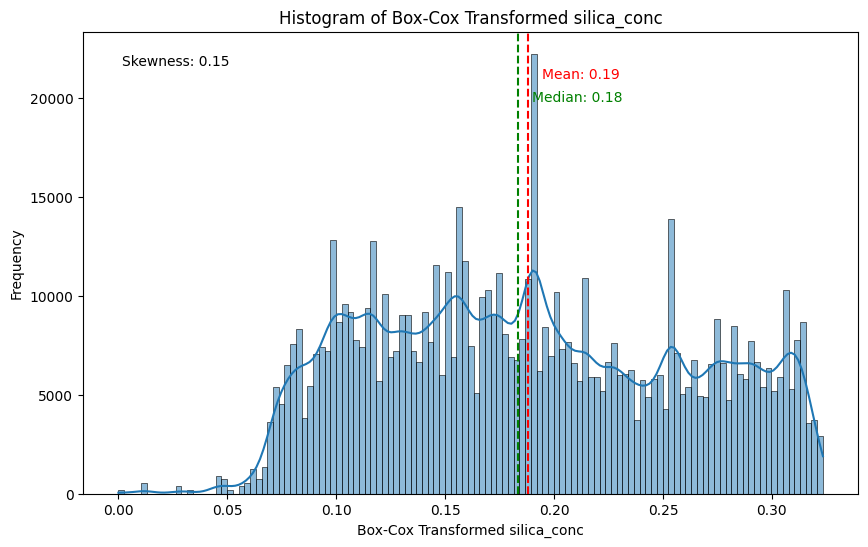

In [184]:
from scipy.stats import boxcox
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))

# Add a constant value to shift the data
shifted_data = flotation['silica_conc'] + abs(min(flotation['silica_conc'])) + 1

# Apply Box-Cox transformation
transformed, lambda_value = boxcox(shifted_data)

# Calculate the skewness of the transformed data
transformed_skewness = skew(transformed)

# Create the histogram of the transformed data
sns.histplot(transformed, kde=True)
plt.axvline(np.mean(transformed), color='r', linestyle='--')
plt.axvline(np.median(transformed), color='g', linestyle='--')
plt.text(np.mean(transformed) + 0.02 * (max(transformed) - min(transformed)), 
         0.9 * plt.ylim()[1], f'Mean: {np.mean(transformed):.2f}', color='r')
plt.text(np.median(transformed) + 0.02 * (max(transformed) - min(transformed)), 
         0.85 * plt.ylim()[1], f'Median: {np.median(transformed):.2f}', color='g')
plt.text(0.05, 0.95, f'Skewness: {transformed_skewness:.2f}', 
         transform=plt.gca().transAxes, ha='left', va='top')

# Set plot title and labels
plt.title('Histogram of Box-Cox Transformed silica_conc')
plt.xlabel('Box-Cox Transformed silica_conc')
plt.ylabel('Frequency')

plt.show()


- We will check skewness of independent variables

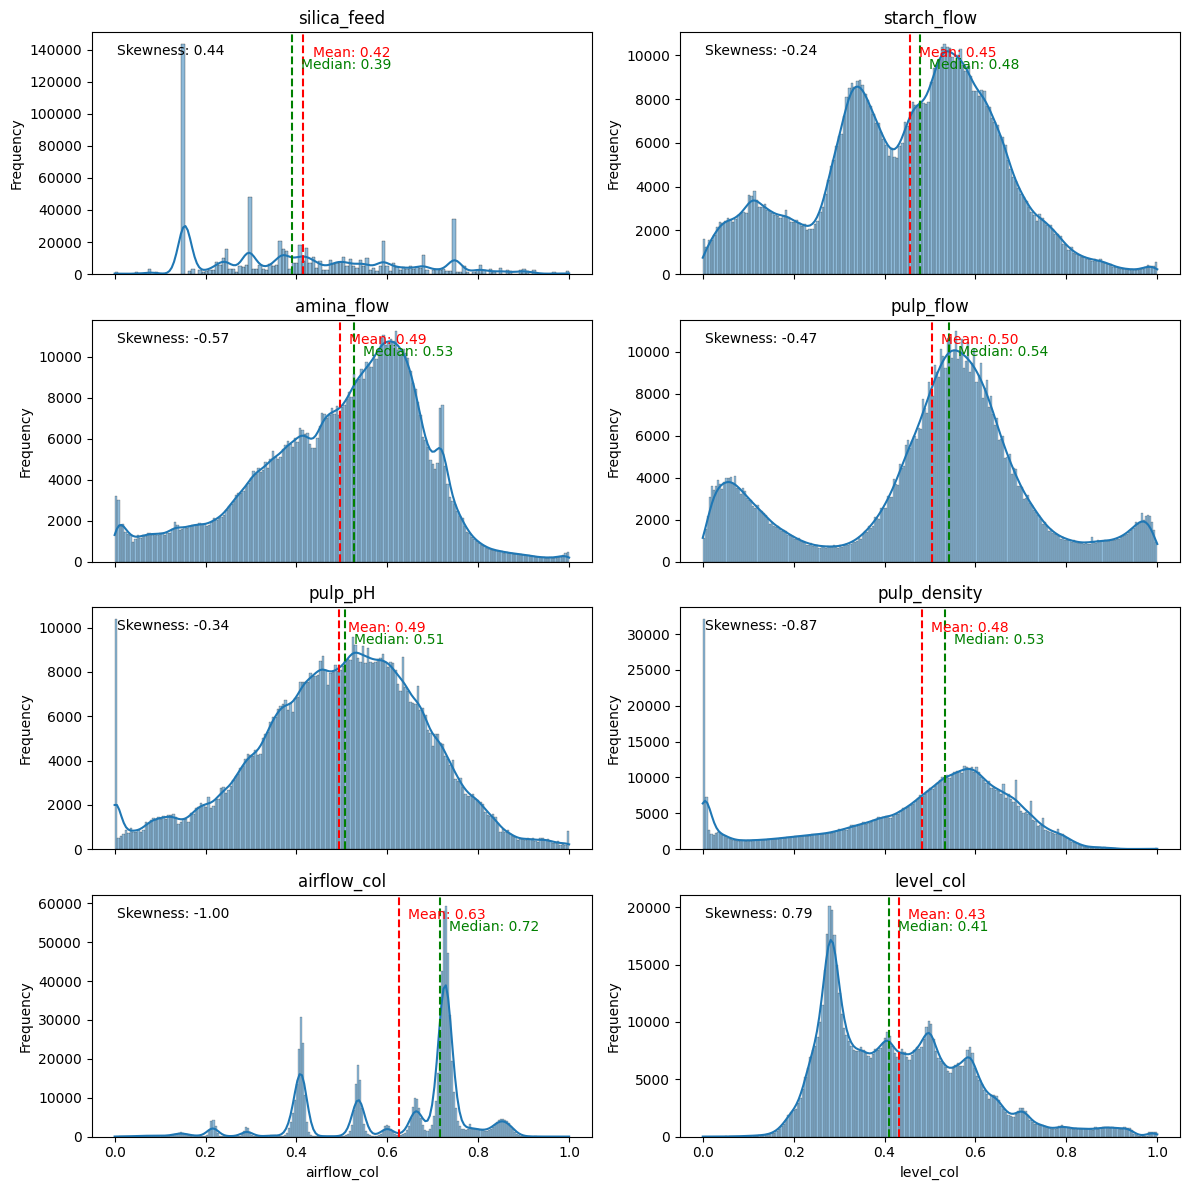

In [185]:
variables = ['silica_feed', 'starch_flow', 'amina_flow', 'pulp_flow', 'pulp_pH',
             'pulp_density', 'airflow_col', 'level_col']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 12), sharex=True)

plt.subplots_adjust(hspace=0.4, wspace=0.3)

for i, variable in enumerate(variables):
    row = i // 2
    col = i % 2

    data = flotation[variable]
    skewness = skew(data)

    sns.histplot(data, kde=True, ax=axes[row, col])
    axes[row, col].axvline(data.mean(), color='r', linestyle='--')
    axes[row, col].axvline(data.median(), color='g', linestyle='--')

    axes[row, col].text(data.mean() + 0.02 * (data.max() - data.min()), 
                        0.9 * axes[row, col].get_ylim()[1], f'Mean: {data.mean():.2f}', color='r')
    axes[row, col].text(data.median() + 0.02 * (data.max() - data.min()), 
                        0.85 * axes[row, col].get_ylim()[1], f'Median: {data.median():.2f}', color='g')

    axes[row, col].text(0.05, 0.95, f'Skewness: {skewness:.2f}', 
                        transform=axes[row, col].transAxes, ha='left', va='top')
    axes[row, col].set_title(variable)
    axes[row, col].set_xlabel(variable)
    axes[row, col].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


- High skewed variables : ```pulp_density'```, ```airflow_col```, ```level_col```
- We will use Boxcox method to eliminate the skewness

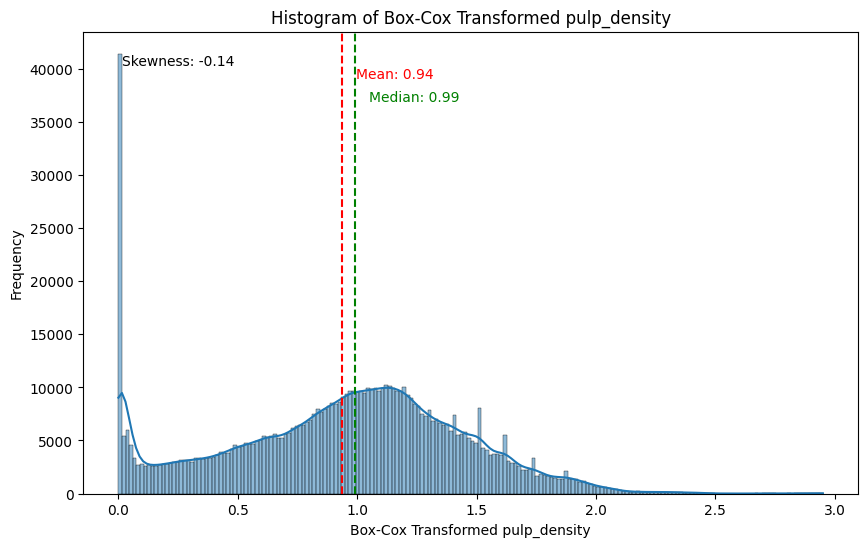

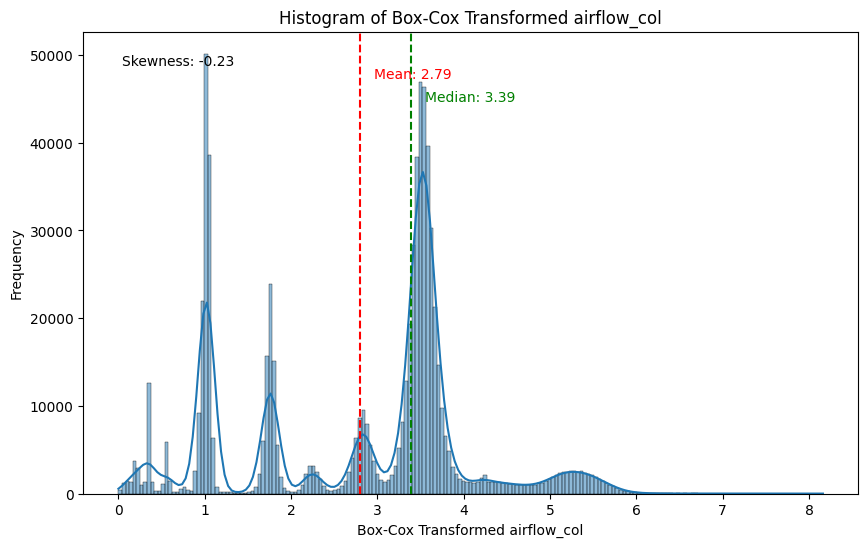

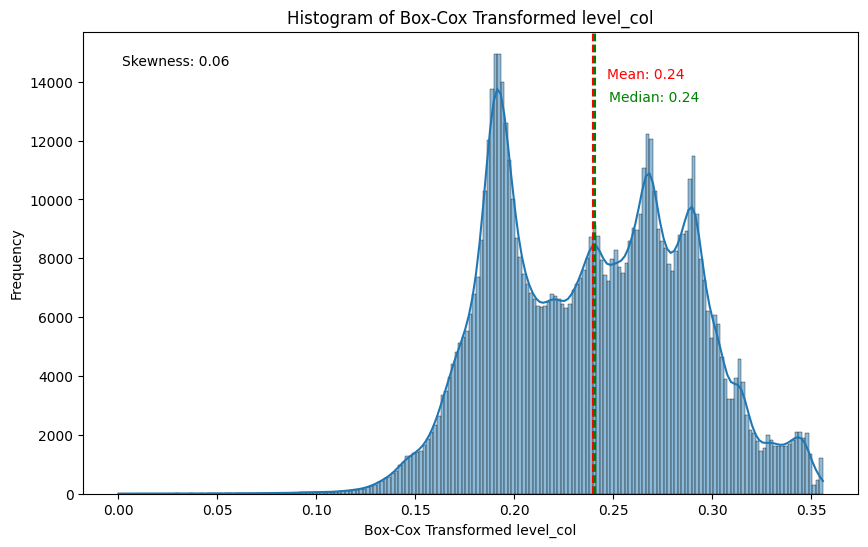

In [186]:
from scipy.stats import boxcox

variables = ['pulp_density', 'airflow_col', 'level_col']

for variable in variables:
    # Add a constant value to shift the data
    shifted_data = flotation[variable] + abs(min(flotation[variable])) + 1

    fig, ax = plt.subplots(figsize=(10, 6))

    # Apply Box-Cox transformation
    transformed, lambda_value = boxcox(shifted_data)

    # Calculate the skewness of the transformed data
    transformed_skewness = skew(transformed)

    # Create the histogram of the transformed data
    sns.histplot(transformed, kde=True)
    plt.axvline(np.mean(transformed), color='r', linestyle='--')
    plt.axvline(np.median(transformed), color='g', linestyle='--')
    plt.text(np.mean(transformed) + 0.02 * (max(transformed) - min(transformed)), 
             0.9 * plt.ylim()[1], f'Mean: {np.mean(transformed):.2f}', color='r')
    plt.text(np.median(transformed) + 0.02 * (max(transformed) - min(transformed)), 
             0.85 * plt.ylim()[1], f'Median: {np.median(transformed):.2f}', color='g')
    plt.text(0.05, 0.95, f'Skewness: {transformed_skewness:.2f}', 
             transform=plt.gca().transAxes, ha='left', va='top')

    # Set plot title and labels
    plt.title(f'Histogram of Box-Cox Transformed {variable}')
    plt.xlabel(f'Box-Cox Transformed {variable}')
    plt.ylabel('Frequency')

    plt.show()


In [187]:
flotation.head().T

,0,1,2,3,4
silica_feed,0.488314,0.488314,0.488314,0.488314,0.488314
starch_flow,0.479273,0.480047,0.483071,0.483690,0.481520
amina_flow,0.634233,0.647351,0.655564,0.656791,0.635705
pulp_flow,0.459144,0.498538,0.552440,0.511653,0.566262
pulp_pH,0.639033,0.639422,0.639812,0.640250,0.640639
pulp_density,0.660348,0.660348,0.660348,0.660348,0.660348
airflow_col,0.416201,0.411241,0.407543,0.418608,0.412390
level_col,0.420156,0.412003,0.409799,0.392673,0.394141
silica_conc,0.144016,0.144016,0.144016,0.144016,0.144016


In [188]:
round(flotation.describe(),2).T

,count,mean,std,min,25%,50%,75%,max
silica_feed,731513.0,0.42,0.21,0.0,0.24,0.39,0.57,1.0
starch_flow,731513.0,0.45,0.19,0.0,0.33,0.48,0.59,1.0
amina_flow,731513.0,0.49,0.18,0.0,0.38,0.53,0.63,1.0
pulp_flow,731513.0,0.50,0.23,0.0,0.43,0.54,0.63,1.0
pulp_pH,731513.0,0.49,0.19,0.0,0.38,0.51,0.62,1.0
pulp_density,731513.0,0.48,0.21,0.0,0.38,0.53,0.63,1.0
airflow_col,731513.0,0.63,0.17,0.0,0.53,0.72,0.73,1.0
level_col,731513.0,0.43,0.16,0.0,0.29,0.41,0.53,1.0
silica_conc,731513.0,0.35,0.23,0.0,0.17,0.28,0.48,1.0


- Relationship between target variable and features

##**5. Modelling**

##**6. Evaluating**

##**7. Tunning Model**